# How to create an initial condition file from a global dataset (here GECCO)

This example shows how to create an Initial condition file for MITgcm from a global model (here GECCO). The first step is to extrapolate
ocean values onto land to avoid contamination by land values in the regridding. The second step is to perform vertical interpolation onto
the model's vertical grid. This is done at this point in the process for compute efficency since the input grid has less horizontal points
than the model's grid. Third, the regridding to the higher resolution grid performed with ESMF bilinear interpolation. For velocities an
extra-step of rotating velocities is required. Finally, we mask the final results with the model's land sea mask.

We are gonna use essentially xarray and packages developed in-house: xmitgcm and MITgcm_recipes

https://github.com/xgcm/xmitgcm

https://github.com/raphaeldussin/MITgcm-recipes

In [1]:
import xarray as xr
import xmitgcm
import MITgcm_recipes
import numpy as np

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 0. Datasets

We need the input dataset (here GECCO), the raw grid from MITgcm (as given by tile00?.mitgrid) that doesn't have holes where land processors are eliminated and one realization of the model for depth vector and grid angles.

#### GECCO is stored locally on our server in netcdf format and loaded with xarray:

In [3]:
geccodir='/local/data/artemis/workspace/rdussin/Simulations/GECCO2/rechunked/'

tempfile = geccodir + 'temp29_34_70.nc'
saltfile = geccodir + 'salt29_34_70.nc'
sshfile = geccodir + 'zeta29_34_70.nc'
SIareafile = geccodir + 'area29_34_70.nc'
SIhefffile = geccodir + 'heff29_34_70.nc'

uzofile = geccodir + 'u29_34_70.nc'
vmefile = geccodir + 'v29_34_70.nc'

# we need to split by point-type to avoid xarray broadcast (makes larger arrays)
gecco_T = xr.open_mfdataset([tempfile, saltfile, sshfile, SIareafile, SIhefffile], decode_times=False, chunks={'time':1})
gecco_U = xr.open_dataset(uzofile, decode_times=False, chunks={'time':1})
gecco_V = xr.open_dataset(vmefile, decode_times=False, chunks={'time':1})

In [4]:
gecco_T
#gecco_U
#gecco_V

<xarray.Dataset>
Dimensions:  (Depth: 50, lat: 180, lon: 360, time: 828)
Coordinates:
  * Depth    (Depth) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.01 85.03 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
Data variables:
    temp     (time, Depth, lat, lon) float32 dask.array<shape=(828, 50, 180, 360), chunksize=(1, 50, 180, 360)>
    salt     (time, Depth, lat, lon) float32 dask.array<shape=(828, 50, 180, 360), chunksize=(1, 50, 180, 360)>
    zeta     (time, lat, lon) float32 dask.array<shape=(828, 180, 360), chunksize=(1, 180, 360)>
    area     (time, lat, lon) float32 dask.array<shape=(828, 180, 360), chunksize=(1, 180, 360)>
    heff     (time, lat, lon) float32 dask.array<shape=(828, 180, 360), chunksize=(1, 180, 360)>
Attributes:
    history:  Mon Jan 28 17:39:22 2019: ncks --cnk_dmn t

Let's pick the first record (Jan 15 1948) for our initial condition: 

In [5]:
gecco_T_ic = gecco_T.sel(time=0)
gecco_U_ic = gecco_U.sel(time=0)
gecco_V_ic = gecco_V.sel(time=0)

#### ASTE raw grid can be read from a netcdf produced with xmitgcm reading tile00?.mitgrid

In [6]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

In [7]:
aste_raw

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, i_g: 270, j: 270, j_g: 270)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5
Data variables:
    XC       (face, j, i) float64 ...
    YC       (face, j, i) float64 ...
    DXF      (face, j, i) float64 ...
    DYF      (face, j, i) float64 ...
    RAC      (face, j, i) float64 ...
    XG       (face, j_g, i_g) float64 ...
    YG       (face, j_g, i_g) float64 ...
    DXV      (face, j, i) float64 ...
    DYU      (face, j, i) float64 ...
    RAZ      (face, j_g, i_g) float64 ...
    DXC      (face, j, i_g) float64 ...
    DYC      (face, j_g, i) float64 ...
    RAW      (face, j, i_g) float64 ...
    RAS      (face, j_g, i)

**Here the variables of interest are gonna be XC, YC and XG, YG which are longitude/latitudes for cell centers and edges**

#### Sample ASTE run needed for angles/depth available at:

In [8]:
datadir_aste = '/local/data/artemis/workspace/rdussin/ASTE/RUNS/ASTE-Phy-Release1/outputs/'
md = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)
aste_out = xmitgcm.open_mdsdataset(datadir_aste, iters=[], prefix=['T','S','Eta','U','V'],
                                   geometry='llc', nx=270, extra_metadata=md)

In [9]:
aste_out

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5
    XC       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    YC       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    XG       (face, j_g, i_g

**Here the variables of interest are CS ( = cos(angle)), SN ( = sin(angle)) and Z (depth vector) **

## 1. Extrapolation onto land (aka Drown)

In [10]:
gecco_drowned_T = xr.Dataset()
drowned_temp = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'temp', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
gecco_drowned_T.update({'temp': drowned_temp['temp']})

<xarray.Dataset>
Dimensions:  (Depth: 50, lat: 180, lon: 360)
Coordinates:
    time     float64 0.0
  * Depth    (Depth) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.01 85.03 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    temp     (Depth, lat, lon) float64 0.574 0.4505 0.3038 0.1496 0.002988 ...

At this point a little check might be useful:

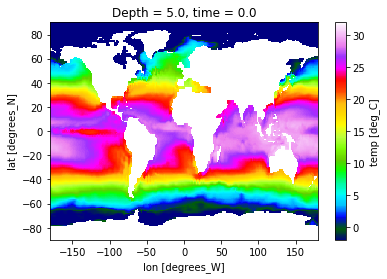

In [11]:
gecco_T_ic['temp'].sel(Depth=5).plot(vmin=-2, vmax=32, cmap='gist_ncar')

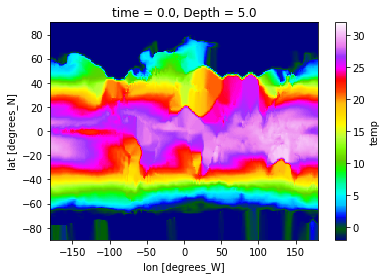

In [12]:
gecco_drowned_T['temp'].sel(Depth=5).plot(vmin=-2, vmax=32, cmap='gist_ncar')

We need a bit of finesse with the ice fields because the ice-free ocean is set to missing value
instead of zero.

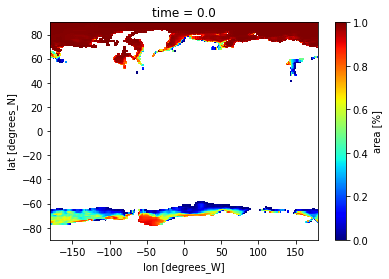

In [13]:
gecco_T_ic['area'].plot(vmin=0, vmax=1, cmap='jet')

In [14]:
gecco_T_ic['heff'] = gecco_T_ic['heff'].fillna(0).where(gecco_T_ic['temp'].sel(Depth=5) <9000)
gecco_T_ic['area'] = gecco_T_ic['area'].fillna(0).where(gecco_T_ic['temp'].sel(Depth=5) <9000)

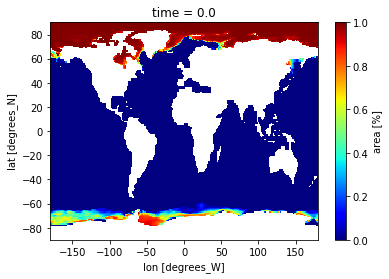

In [15]:
gecco_T_ic['area'].plot(vmin=0, vmax=1, cmap='jet')

The ocean point are kept intact but land points are filled with ocean values. Let's now proceed with the other variables:

In [16]:
# salt
drowned_salt = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'salt', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
gecco_drowned_T.update({'salt': drowned_salt['salt']})

# ssh
drowned_zeta = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'zeta', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
gecco_drowned_T.update({'zeta': drowned_zeta['zeta']})

# SeaIce
drowned_area = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'area', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
gecco_drowned_T.update({'area': drowned_area['area']})

drowned_heff = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'heff', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
gecco_drowned_T.update({'heff': drowned_heff['heff']})

# Velocities
gecco_drowned_U = MITgcm_recipes.regridding.drown_field(gecco_U_ic, 'u', dims_drown=['lat', 'lon'], 
                                                        mask=None, periodicity=0)

gecco_drowned_V = MITgcm_recipes.regridding.drown_field(gecco_V_ic, 'v', dims_drown=['lat', 'lon'], 
                                                        mask=None, periodicity=0)

## 2. Vertical interpolation

GECCO and ASTE have the same vertical grid but we need to change the vertical coordinate name:

In [17]:
# Tpoint
gecco_drowned_Tz = MITgcm_recipes.vertical_interpolation(gecco_drowned_T, aste_out['Z'], ['temp', 'salt'],
                                                         lonvar='lon', latvar='lat',
                                                         depth_varin='Depth',
                                                         timevar=None)

# add ssh and SeaIce (2d) to resulting dataset
gecco_drowned_Tz.update({'zeta':gecco_drowned_T['zeta'],
                         'area':gecco_drowned_T['area'],
                         'heff':gecco_drowned_T['heff']})

# U point
gecco_drowned_Uz = MITgcm_recipes.vertical_interpolation(gecco_drowned_U, aste_out['Z'], ['u'],
                                                         lonvar='lon', latvar='lat',
                                                         depth_varin='Depth',
                                                         timevar=None)

# V point
gecco_drowned_Vz = MITgcm_recipes.vertical_interpolation(gecco_drowned_V, aste_out['Z'], ['v'],
                                                         lonvar='lon', latvar='lat',
                                                         depth_varin='Depth',
                                                         timevar=None)

In [18]:
gecco_drowned_Tz

<xarray.Dataset>
Dimensions:  (k: 50, lat: 180, lon: 360)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
    time     float64 0.0
    drF      (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    PHrefC   (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
Data variables:
    Z        (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    temp     (k, lat, lon) float64 0.574 0.4505 0.3038 0.1496 0.002988 ...
    salt     (k, lat, lon) float64 34.02 33.99 33.94 33.89 33.84 33.79 33.73 ...
    zeta     (lat, lon) float32 -1.7550281 -1.7544596 -1.753652 -1.7526021 ...
    area     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    heff     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

## 3. Regridding onto ASTE grid

### 3.1 Scalars

For scalars, we need to regrid from GECCO cell center onto cell centers of the ASTE grid. We control the origin lon/lat with lonname/latname that should point to cell center (in our case we work with 3 datasets on each U,V and T point all named lon/lat). The point='T' argument will pick MITgcm's XC/YC as our target coordinantes from the ASTE raw grid.
Bilinear interpolation has issues with the north pole (on face 2) so we use a nearest neighbour interpolation as our backup that we're gonna blend with the results of the bilinear (faces2blend=[2]). Original grid is periodic. However, during the regridding process, we subset the source grid to the dimensions of each face for computional efficiency. This process can break the periodicity and is accounted for.

In [19]:
mask_face2 = np.ones((270, 270))
mask_face2[130:140,130:140] = 0
mask_north_pole = {2: mask_face2}

In [20]:
regrid_T = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Tz, aste_raw, 
                                                         ['temp', 'salt', 'zeta', 'area', 'heff'], 
                                                         method='bilinear',
                                                         lonname='lon', latname='lat', point='T', 
                                                         faces2blend=[2], blend_mask=mask_north_pole, 
                                                         periodic=True, reuse_weights=False)

Create weight file: regrid_face0.nc
Create weight file: regrid_face1.nc
Create weight file: regrid_face2.nc
Creating nearest neighbor weights for face 2
Create weight file: backup_regrid_face2.nc
Create weight file: regrid_face3.nc
Create weight file: regrid_face4.nc
Create weight file: regrid_face5.nc
running nn regridding for face 2
running nn regridding for face 2
running nn regridding for face 2
running nn regridding for face 2
running nn regridding for face 2


The regridded dataset for scalars now has the same dimensions as ASTE

In [21]:
regrid_T

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, j: 270, k: 50)
Coordinates:
    time     float64 0.0
    drF      (k) >f4 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.01 10.03 10.11 ...
    PHrefC   (k) >f4 49.05 147.15 245.25 343.35 441.45 539.55 637.65 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5
Data variables:
    temp     (face, k, j, i) float64 28.17 28.17 28.17 28.17 28.17 28.17 ...
    salt     (face, k, j, i) float64 35.63 35.63 35.63 35.63 35.63 35.63 ...
    zeta     (face, j, i) float64 0.0236 0.0236 0.0236 0.0236 0.0236 0.0236 ...
    area     (face, j, i) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    heff     (face, j, i) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

The fields contain the extrapolated values on land:

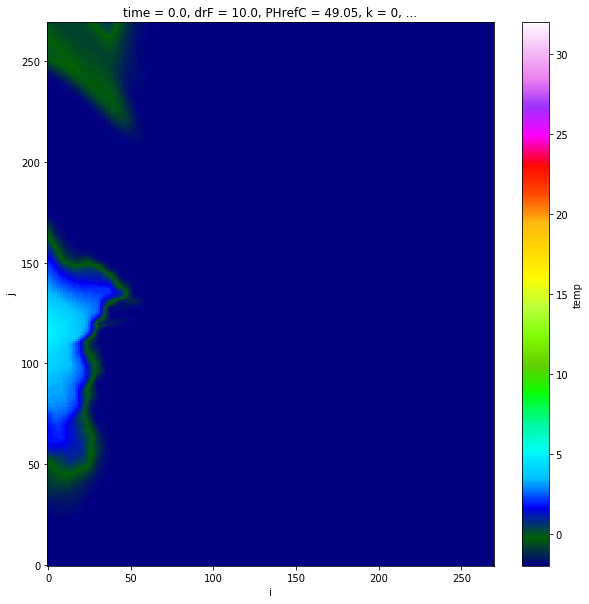

In [22]:
regrid_T.temp.sel(face=2, k=0).plot(vmin=-2,vmax=32, cmap='gist_ncar', figsize=[10,10])

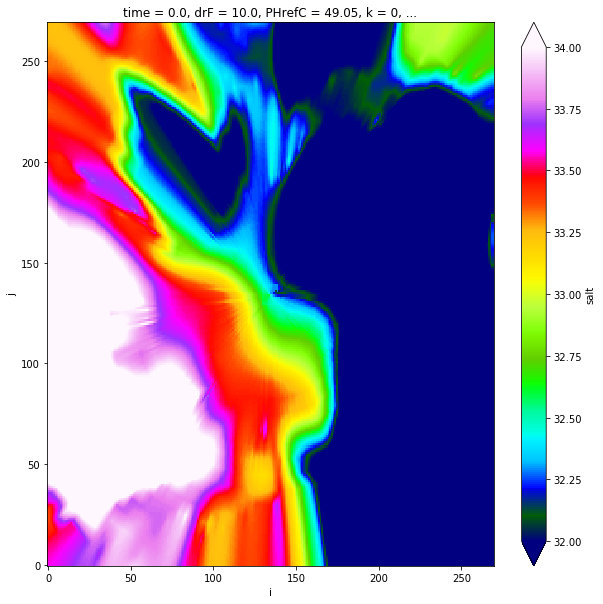

In [23]:
regrid_T.salt.sel(face=2, k=0).plot(vmin=32,vmax=34, cmap='gist_ncar', figsize=[10,10])

If desired, we can mask it with special values (for analysis) with the **mask_output** function or zeros with the **mask_output_zeros** function (to write input file for MITgcm)

In [24]:
masked_temp = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.temp, aste_out, point='T')

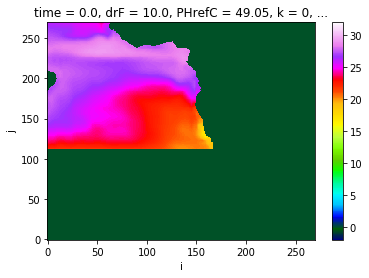

In [25]:
masked_temp.sel(face=0,k=0).plot(vmin=-2,vmax=32, cmap='gist_ncar')

Make sure we don't have temperature below freezing point

In [26]:
masked_temp = masked_temp.clip(min=-1.8)

Using ASTE xmitgcm metadata (md), we can reconstruct the compact form for the llc data and write this into a binary file:

In [27]:
facets = xmitgcm.utils.rebuild_llc_facets(masked_temp, md)
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z', md)
xmitgcm.utils.write_to_binary(compact, 'temp_GECCO_19480115.bin', precision='double')

Do the same for other variables

In [28]:
masked_salt = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.salt, aste_out, point='T')

In [29]:
facets = xmitgcm.utils.rebuild_llc_facets(masked_salt, md)
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z', md)
xmitgcm.utils.write_to_binary(compact, 'salt_GECCO_19480115.bin', precision='double')

In [30]:
masked_zeta = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.zeta, aste_out, point='T')

In [31]:
facets = xmitgcm.utils.rebuild_llc_facets(masked_zeta, md)
compact = xmitgcm.utils.llc_facets_2d_to_compact(facets, md)
xmitgcm.utils.write_to_binary(compact, 'zeta_GECCO_19480115.bin', precision='double')

In [32]:
masked_area = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.area, aste_out, point='T')

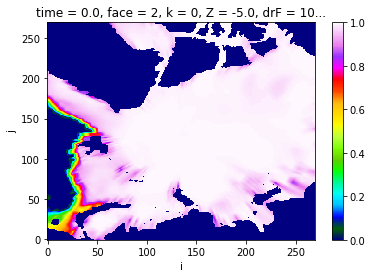

In [33]:
masked_area.sel(face=2).plot(vmin=0,vmax=1, cmap='gist_ncar')

In [34]:
facets = xmitgcm.utils.rebuild_llc_facets(masked_area, md)
compact = xmitgcm.utils.llc_facets_2d_to_compact(facets, md)
xmitgcm.utils.write_to_binary(compact, 'area_GECCO_19480115.bin', precision='double')

In [35]:
masked_heff = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.heff, aste_out, point='T')

In [36]:
facets = xmitgcm.utils.rebuild_llc_facets(masked_heff, md)
compact = xmitgcm.utils.llc_facets_2d_to_compact(facets, md)
xmitgcm.utils.write_to_binary(compact, 'heff_GECCO_19480115.bin', precision='double')

### 3.1 Vectors (velocities)

In the case of velocities, things get a little more complicated: each component (u,v) needs to be interpolated from its source point to both MITgcm's U and V points and then rotated according to the grid angle. The model's u velocity will then be *U_at_u_point * cos(angle) + V_at_u_point * sin(angle)*,... Be careful not to reuse the same weights for U and V points!

In [37]:
# Perform 4 interpolations!

rawUvel_Upoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Uz, aste_raw, ['u'], point='U',
                                                               method='bilinear',
                                                               periodic=True, reuse_weights=False)

rawUvel_Vpoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Uz, aste_raw, ['u'], point='V',
                                                               method='bilinear',
                                                               periodic=True, reuse_weights=False)



rawVvel_Upoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Vz, aste_raw, ['v'], point='U',
                                                               method='bilinear',
                                                               periodic=True, reuse_weights=False)

rawVvel_Vpoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Vz, aste_raw, ['v'], point='V',
                                                               method='bilinear',
                                                               periodic=True, reuse_weights=False)

Overwrite existing file: regrid_face0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face4.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face5.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing f

Rotation of the velocities: this part is less satisfying... angle is taken at cell-center when it should be interpolated at cell edges. I can live with that because 
the rotation is either zero or 90 degrees in most cases. The rest will affect slightly the initial condition but will be spun up. Velocities at the boundary are either at zero angle or 90 degree angle. To hack the angles, I change the coodinate name to U or V point. 

In [38]:
u_aste =   rawUvel_Upoint['u'] * aste_out['CS'].rename({'i':'i_g'}) + rawVvel_Upoint['v'] * aste_out['SN'].rename({'i':'i_g'})
v_aste = - rawUvel_Vpoint['u'] * aste_out['SN'].rename({'j':'j_g'}) + rawVvel_Vpoint['v'] * aste_out['CS'].rename({'j':'j_g'})

Mask the end result with zeros

In [39]:
masked_u = MITgcm_recipes.regridding.mask_output_zeros(u_aste, aste_out, point='U')

In [40]:
masked_v = MITgcm_recipes.regridding.mask_output_zeros(v_aste, aste_out, point='V')

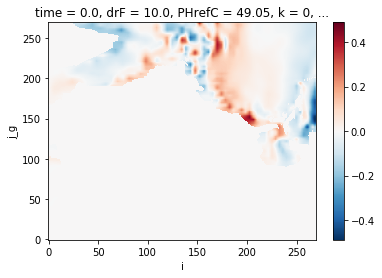

In [41]:
masked_v.sel(face=4,k=0).plot()

In [42]:
facets = xmitgcm.utils.rebuild_llc_facets(masked_u, md)
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z', md)
xmitgcm.utils.write_to_binary(compact, 'u_GECCO_19480115.bin', precision='double')

In [43]:
facets = xmitgcm.utils.rebuild_llc_facets(masked_v, md)
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z', md)
xmitgcm.utils.write_to_binary(compact, 'v_GECCO_19480115.bin', precision='double')